# Kurtosis Portfolio Optimization

In this notebook we show how to use the semidefinite cone and second order cone to model the optimization of portfolio kurtosis.

## <font color='red'> Warning: Don't use this model for n >= 30 without Mosek and I don't recommend to calculate $L_2$, $D_2$, $S_2$ and $\Sigma_4$ for n >= 30 with Python (Use C++ and Armadillo library) </font>

## 1. Kurtosis Minimization

The minimization of portfolio kurtosis, as shown in __[Cajas (2022)](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=4202967)__, can be posed as a convex problem as follows:

$$
\begin{equation}
\begin{aligned}
\min_{x, \, X, \, z, \, g} \; &  g \\
& \left [ \begin{array}{cc} X & x \\ x^{\prime} & 1 \end{array} \right ] \succeq 0 \\
& z = L_{2} \text{vec}(X) \\
& \left \| \left [ S_{2} \Sigma_{4} S^{\prime}_{2} \right ]^{1/2} z \right \|_{2} \leq g \\
& \sum^{n}_{i=1}x_{i} = 1 \\
& x \geq 0 \\
& X \succeq 0 \\
\end{aligned}
\end{equation}
$$

where:
<br>$g$: is an auxiliary variable that represents the square root of portfolio kurtosis
<br>$\Sigma_{4}$: is the square co-kurtosis matrix.
<br>$x$: is the vector of portfolio weights of size $n \times 1$
<br>$X$: is an auxiliary variable of size $n \times n$ that is positive semidefinite.
<br>$D_{2}$: is the duplication efined in __[Magnus (1980)](https://pure.uvt.nl/ws/portalfiles/portal/649691/26951_6623.pdf)__.
<br>$L_{2}$: is the duplication elimination matrix defined in __[Magnus (1980)](https://pure.uvt.nl/ws/portalfiles/portal/649691/26951_6623.pdf)__.
<br>$S_{2}$ is the duplication summation matrix defined as $S_{2} = D^{\prime}_{2}D_{2}L_{2}$
<br>$\text{vec}$: is the vectorization operator.

In [1]:
####################################
# Downloading Data
####################################
!pip install --quiet yfinance

import numpy as np
import pandas as pd
import yfinance as yf
from itertools import permutations
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

import warnings

warnings.filterwarnings("ignore")

yf.pdr_override()
pd.options.display.float_format = '{:.4%}'.format

# Date range
start = '2016-01-01'
end = '2021-12-30'

# Tickers of assets
assets = ['TGT', 'CMCSA', 'CPB', 'MO', 'T', 'BAX', 'BMY',
          'MSFT', 'SEE', 'VZ', 'CNP', 'NI', 'GE', 'GOOG']
assets.sort()

# Downloading data
data = yf.download(assets, start = start, end = end)
data = data.loc[:,('Adj Close', slice(None))]
data.columns = assets

# Calculating returns
Y = data[assets].pct_change().dropna()

display(Y.head())

[*********************100%***********************]  14 of 14 completed


,BAX,BMY,CMCSA,CNP,CPB,GE,GOOG,MO,MSFT,NI,SEE,T,TGT,VZ
Date,,,,,,,,,,,,,,
2016-01-05,0.4036%,1.9693%,0.0180%,0.9305%,0.3678%,0.0977%,0.0998%,2.0212%,0.4562%,1.5881%,0.9758%,0.6987%,1.7539%,1.3735%
2016-01-06,0.2412%,-1.7557%,-0.7727%,-1.2473%,-0.1736%,-1.5940%,0.1400%,1.0589%,-1.8165%,0.5547%,-1.5647%,0.3108%,-1.0155%,-0.9035%
2016-01-07,-1.6573%,-2.7699%,-1.1047%,-1.9770%,-1.2206%,-4.2314%,-2.3170%,-1.7407%,-3.4783%,-2.2066%,-3.1557%,-1.6148%,-0.2700%,-0.5492%
2016-01-08,-1.6037%,-2.5425%,0.1099%,-0.2241%,0.5706%,-1.7950%,-1.6410%,0.1720%,0.3067%,-0.1538%,-0.1448%,0.0895%,-3.3839%,-0.9719%
2016-01-11,-1.6850%,-1.0215%,0.0914%,-1.1791%,0.5674%,0.4570%,0.2183%,2.0948%,-0.0573%,1.6436%,-0.1450%,1.2224%,1.4570%,0.5800%


In [2]:
####################################
# Auxiliary functions
####################################

# Function that calculates D_2
def duplication_matrix(n):
    out = np.zeros((int(n*(n+1)/2), n**2))
    for j in range(1, n+1):
        for i in range(j, n+1):
            u = np.zeros((int(n*(n+1)/2), 1))
            u[round((j-1)*n + i - ((j-1)*j)/2)-1] = 1.0
            E = np.zeros((n,n))
            E[i-1,j-1] = 1.0
            E[j-1,i-1] = 1.0
            out += u @ E.reshape(-1,1).T;
    return out.T

# Function that calculates L_2
def duplication_elimination_matrix(n):
    out = np.zeros((int(n*(n+1)/2), n**2))
    for j in range(n):
        e_j = np.zeros((1, n))
        e_j[0, j] = 1.0
        for i in range(j, n):
            u = np.zeros((int(n*(n+1)/2), 1))      
            row = round(j*n+i-((j+1)*j)/2)
            u[row] = 1.0
            e_i = np.zeros((1, n))
            e_i[0,i] = 1.0
            out += np.kron(u, np.kron(e_j, e_i))
    return out

# Function that calculates S_4
def kurt_matrix(Y):
    P = Y.to_numpy()
    T, n = P.shape
    mu = np.mean(P, axis=0).reshape(1,-1)
    mu = np.repeat(mu, T, axis=0)
    x = P - mu
    ones = np.ones((1,n))
    z = np.kron(ones, x) * np.kron(x, ones);
    S4 = 1/T * z.T @ z
    return S4

In [3]:
####################################
# Finding the Min Kurtosis Portfolio
####################################

import cvxpy as cp
#import mosek
from scipy.linalg import sqrtm

# Parameters 
T, n = Y.shape

D_2 = duplication_matrix(n)
L_2 = duplication_elimination_matrix(n)
S_2 = D_2.T @ D_2 @ L_2

Sigma_4 = kurt_matrix(Y)
Sigma_4_sqrt = sqrtm(S_2 @ Sigma_4 @ S_2.T)

# Variables
rows = int(n*(n+1)/2)
x = cp.Variable((n,1))
z = cp.Variable((rows,1))
X = cp.Variable((n,n), PSD=True)
g = cp.Variable()

risk = g
constraints = [cp.sum(x) == 1,
               x >= 0,
               z == L_2 @ cp.reshape(cp.vec(X), (n*n,1)),
              ]
 
M1 = cp.vstack([X, x.T])
M2 = cp.vstack([x, np.ones((1, 1))])
M3 = cp.hstack([M1, M2])

constraints += [
                cp.SOC(g, Sigma_4_sqrt @ z),
                M3 >> 0,
               ]

obj = cp.Minimize(risk * 1000)
prob = cp.Problem(obj, constraints)

#prob.solve(solver='MOSEK', mosek_params= {mosek.iparam.num_threads: 2})
prob.solve()
w = pd.DataFrame(x.value, index=assets, columns=['weights'])
display(w)

,weights
BAX,0.0000%
BMY,21.0918%
CMCSA,0.0000%
CNP,0.0000%
CPB,22.6310%
GE,0.0000%
GOOG,8.5224%
MO,0.0000%
MSFT,0.0000%
NI,0.0000%


In [4]:
####################################
# Finding the Min Variance Portfolio
####################################

!pip install --quiet riskfolio-lib
import riskfolio as rp

# Building the portfolio object
port = rp.Portfolio(returns=Y)

# Calculating optimum portfolio

# Select method and estimate input parameters:

method_mu='hist' # Method to estimate expected returns based on historical data.
method_cov='hist' # Method to estimate covariance matrix based on historical data.

port.assets_stats(method_mu=method_mu, method_cov=method_cov, d=0.94)

# Estimate optimal portfolio:

port.solvers = [cp.MOSEK]
model='Classic' # Could be Classic (historical), BL (Black Litterman) or FM (Factor Model)
rm = 'MV' # Risk measure used, this time will be EVaR
obj = 'MinRisk' # Objective function, could be MinRisk, MaxRet, Utility or Sharpe
hist = True # Use historical scenarios for risk measures that depend on scenarios
rf = 0 # Risk free rate
l = 0 # Risk aversion factor, only useful when obj is 'Utility'

w2 = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)

display(w2)

,weights
BAX,8.4725%
BMY,12.6225%
CMCSA,1.5316%
CNP,0.0000%
CPB,15.1034%
GE,0.0000%
GOOG,9.8518%
MO,7.1117%
MSFT,0.0000%
NI,2.9515%


In [5]:
####################################
# Montecarlo Simulation
####################################

# Montecarlo simulation of portfolio weights
rs = np.random.RandomState(seed=123)
s1 = rs.dirichlet([0.1] * len(assets), 10000)
s2 = rs.dirichlet([0.25] * len(assets), 10000)
s3 = rs.dirichlet([0.5] * len(assets), 10000)
s4 = rs.dirichlet([0.75] * len(assets), 10000)
s5 = rs.dirichlet([1.0] * len(assets), 10000)
s6 = rs.dirichlet([1.5] * len(assets), 10000)
s7 = rs.dirichlet([2.0] * len(assets), 10000)
s8 = rs.dirichlet([3.0] * len(assets), 10000)
sample = np.concatenate([np.identity(len(assets)), s1, s2, s3, s4, s5, s6, s7, s8], axis=0)

# Calculating mean, standard deviation and square root kurtosis of each portfolio
m = sample.shape[0]
M_1 = np.mean(Y.to_numpy(), axis=0).reshape(1,-1)
M_2 = Y.cov().to_numpy()

c_mean = M_1 @ sample.T
c_var = np.zeros(m)
c_kurt = np.zeros(m)

for i in range(0, m):
    c_var[i] = (sample[i] @ M_2 @ sample[i].T) ** (0.5)
    c_kurt[i] = (np.kron(sample[i], sample[i]) @ Sigma_4 @ np.kron(sample[i],sample[i]).T) ** (1/4)

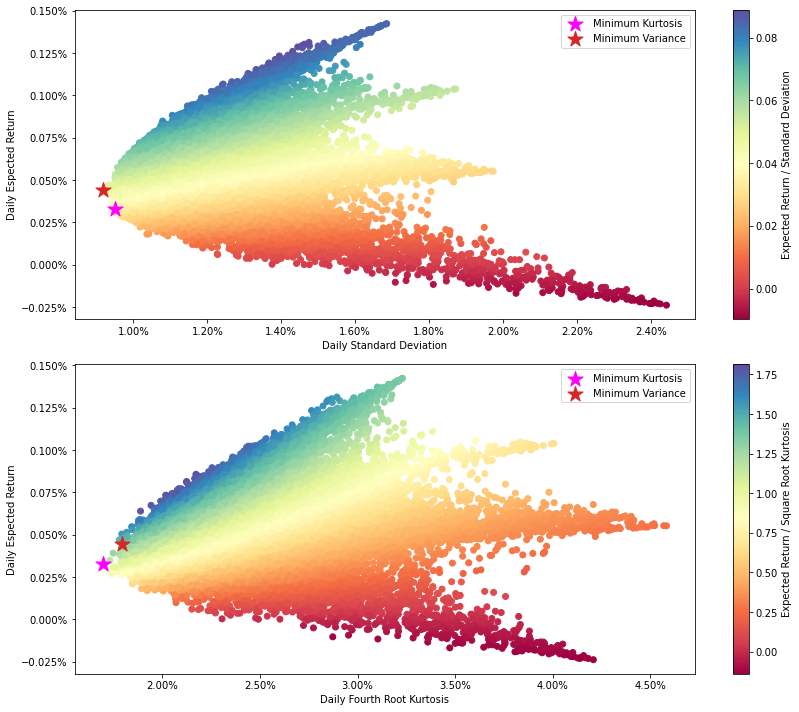

In [6]:
####################################
# Plotting Portfolios
####################################

fig, ax = plt.subplots(2, 1, figsize=(12,10))
ax = np.ravel(ax)

# Plotting Portfolios in mean-standard deviation plane
cax0 = ax[0].scatter(c_var, c_mean, c=c_mean/c_var, cmap='Spectral')
ax[0].scatter((w.to_numpy().T @ M_2 @ w.to_numpy()) ** (0.5),
              M_1 @ w.to_numpy(),
              marker='*',
              s=2**8,
              color='fuchsia',
              label='Minimum Kurtosis')
ax[0].scatter((w2.to_numpy().T @ M_2 @ w2.to_numpy()) ** (0.5),
              M_1 @ w2.to_numpy(),
              marker='*',
              s=2**8,
              color='tab:red',
              label='Minimum Variance')

# Plotting Portfolios in mean-square root kurtosis plane
cax1 = ax[1].scatter(c_kurt, c_mean, c=c_mean/c_kurt**2, cmap='Spectral')
ax[1].scatter((np.kron(w.to_numpy(), w.to_numpy()).T @ Sigma_4 @ np.kron(w.to_numpy(), w.to_numpy())) ** (0.25),
              M_1 @ w.to_numpy(),
              marker='*',
              s=2**8,
              color='fuchsia',
              label='Minimum Kurtosis')
ax[1].scatter((np.kron(w2.to_numpy(), w2.to_numpy()).T @ Sigma_4 @ np.kron(w2.to_numpy(), w2.to_numpy())) ** (0.25),
              M_1 @ w2.to_numpy(),
              marker='*',
              s=2**8,
              color='tab:red',
              label='Minimum Variance')

fig.colorbar(cax0, ax=ax[0], label='Expected Return / Standard Deviation')
fig.colorbar(cax1, ax=ax[1], label='Expected Return / Square Root Kurtosis')

ax[0].xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
ax[0].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
ax[0].set_xlabel('Daily Standard Deviation')
ax[0].set_ylabel('Daily Espected Return')
ax[0].legend()

ax[1].xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
ax[1].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
ax[1].set_xlabel('Daily Fourth Root Kurtosis')
ax[1].set_ylabel('Daily Espected Return')
ax[1].legend()

fig.tight_layout()

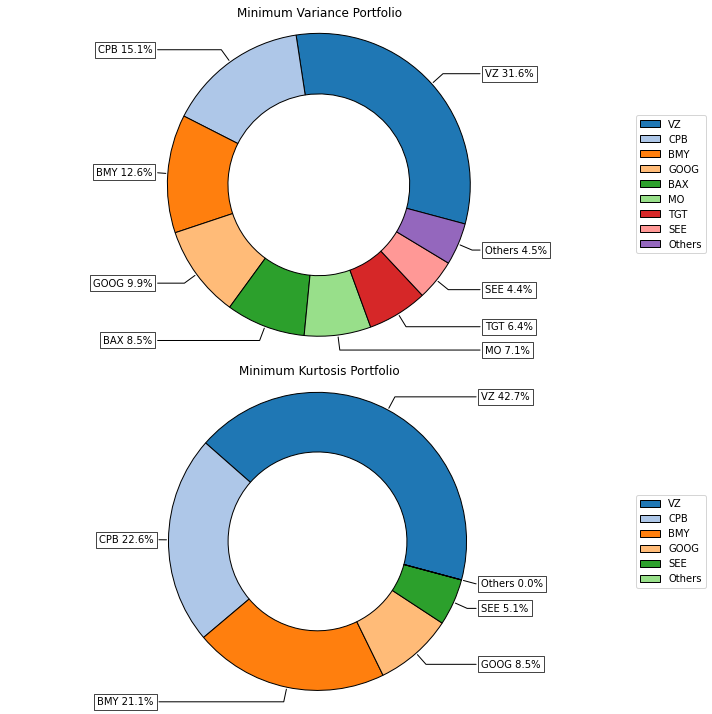

In [7]:
####################################
# Plotting Portfolios Composition
####################################

fig, ax = plt.subplots(2, 1, figsize=(10,10))
ax = np.ravel(ax)

rp.plot_pie(w=w2,
            title='Minimum Variance Portfolio',
            others=0.05,
            nrow=25,
            ax=ax[0])

rp.plot_pie(w=w,
            title='Minimum Kurtosis Portfolio',
            others=0.05,
            nrow=25,
            ax=ax[1])

fig.tight_layout()

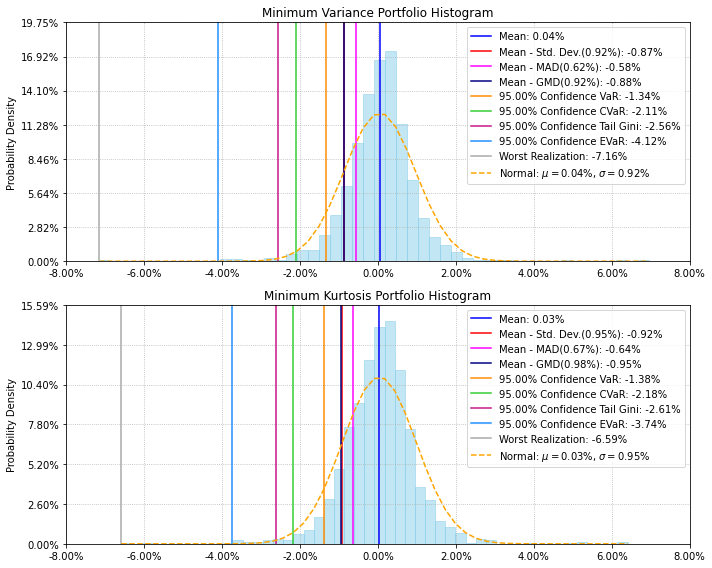

In [8]:
####################################
# Plotting Portfolios Histogram
####################################

fig, ax = plt.subplots(2, 1, figsize=(10,8))
ax = np.ravel(ax)

rp.plot_hist(returns=Y,
             w=w2,
             alpha=0.05,
             bins=50,
             ax=ax[0])

rp.plot_hist(returns=Y,
             w=w,
             alpha=0.05,
             bins=50,
             ax=ax[1])

ax[0].set_title('Minimum Variance Portfolio Histogram')
ax[1].set_title('Minimum Kurtosis Portfolio Histogram')

fig.tight_layout()

We can see that the minimum kurtosis portfolio reduce the tails of portfolio returns distribution compared to minimun variance portfolio because more conservative downside risk measures like Entropic Value at Risk and Worst realization are lower for the minimum kurtosis portfolio.

This portfolio optimization model will be added soon to the CVXPY based library __[Riskfolio-Lib](https://github.com/dcajasn/Riskfolio-Lib)__.